In [1]:
import xml.etree.ElementTree as ET
import os

xml_folder = "US-Road-Signs-71/easy/Annotations"
output_folder = "US-Road-Signs-71/easy/labels"
os.makedirs(output_folder, exist_ok=True)

def clip(val, minv, maxv):
    return max(minv, min(val, maxv))

def get_class_id(name: str):
    name = name.strip().upper()

    if name == "R1-1":
        return 1   # stop

    if name.startswith("W"):
        return 2   # warning

    if name.startswith("R"):
        return 0   # regulatory

    return None    # skip everything else


total = 0
kept = 0
skipped = 0

for xml_file in os.listdir(xml_folder):
    if not xml_file.endswith(".xml"):
        continue

    xml_path = os.path.join(xml_folder, xml_file)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find("filename").text
    width = int(root.find("size/width").text)
    height = int(root.find("size/height").text)

    yolo_lines = []

    for obj in root.findall("object"):
        total += 1

        class_name = obj.find("name").text.strip()
        class_id = get_class_id(class_name)

        if class_id is None:
            skipped += 1
            continue

        box = obj.find("bndbox")
        xmin = float(box.find("xmin").text)
        ymin = float(box.find("ymin").text)
        xmax = float(box.find("xmax").text)
        ymax = float(box.find("ymax").text)

        # Clip to image bounds
        xmin = clip(xmin, 0, width)
        xmax = clip(xmax, 0, width)
        ymin = clip(ymin, 0, height)
        ymax = clip(ymax, 0, height)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2.0 / width
        y_center = (ymin + ymax) / 2.0 / height
        box_w = (xmax - xmin) / width
        box_h = (ymax - ymin) / height

        yolo_lines.append(
            f"{class_id} {x_center:.6f} {y_center:.6f} {box_w:.6f} {box_h:.6f}"
        )

        kept += 1

    # Save file only if annotations exist
    if yolo_lines:
        label_file = os.path.join(output_folder, filename.replace(".jpg", ".txt"))
        with open(label_file, "w") as f:
            f.write("\n".join(yolo_lines))

print("\n✅ Conversion completed")
print(f"Total objects: {total}")
print(f"Kept: {kept}")
print(f"Skipped: {skipped}")


✅ Conversion completed
Total objects: 16540
Kept: 6895
Skipped: 9645


In [2]:
import cv2
import numpy as np
import random
# /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/challenging/JPEGImages
image_folder = "US-Road-Signs-71/easy/JPEGImages"
annotation_folder = "US-Road-Signs-71/easy/labels"
label_file = random.choice(os.listdir(annotation_folder))

if not label_file.endswith(".txt"):
    exit()

label_path = os.path.join(annotation_folder, label_file)
image_path = os.path.join(image_folder, label_file.replace(".txt", ".jpg"))

image = cv2.imread(image_path)
h, w, _ = image.shape

with open(label_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center = float(parts[1]) * w
        y_center = float(parts[2]) * h
        box_w = float(parts[3]) * w
        box_h = float(parts[4]) * h

        xmin = int(x_center - box_w / 2)
        ymin = int(y_center - box_h / 2)
        xmax = int(x_center + box_w / 2)
        ymax = int(y_center + box_h / 2)

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)

cv2.imshow("Image", image)
cv2.waitKey(5000)
cv2.destroyAllWindows()

In [4]:
import shutil
images_folder = "US-Road-Signs-71/easy/JPEGImages"
labels_folder = "US-Road-Signs-71/easy/labels"

items = os.listdir(labels_folder)
train = len(items) * 80 // 100
valid = len(items) * 10 // 100
test = len(items) - train - valid

print(f"Total items: {len(items)}")
print(f"Train: {train}, Valid: {valid}, Test: {test}")

Total items: 5085
Train: 4068, Valid: 508, Test: 509


In [5]:

train_items = random.sample(items, train)
remaining_items = list(set(items) - set(train_items))
valid_items = random.sample(remaining_items, valid)
test_items = list(set(remaining_items) - set(valid_items))

for train_item in train_items:
    shutil.move(os.path.join(labels_folder, train_item), os.path.join("US-Road-Signs-71/easy/train/labels", train_item))
    shutil.move(os.path.join(images_folder, train_item.replace(".txt", ".jpg")), os.path.join("US-Road-Signs-71/easy/train/images", train_item.replace(".txt", ".jpg")))
for valid_item in valid_items:
    shutil.move(os.path.join(labels_folder, valid_item), os.path.join("US-Road-Signs-71/easy/valid/labels", valid_item))
    shutil.move(os.path.join(images_folder, valid_item.replace(".txt", ".jpg")), os.path.join("US-Road-Signs-71/easy/valid/images", valid_item.replace(".txt", ".jpg")))
for test_item in test_items:
    shutil.move(os.path.join(labels_folder, test_item), os.path.join("US-Road-Signs-71/easy/test/labels", test_item))
    shutil.move(os.path.join(images_folder, test_item.replace(".txt", ".jpg")), os.path.join("US-Road-Signs-71/easy/test/images", test_item.replace(".txt", ".jpg")))

In [6]:
from ultralytics import YOLO
model = YOLO("runs_us_signs/yolov8s_us_signs2/weights/best.pt")
results = model.train(
    data="US-Road-Signs-71/tester.yaml",      # path to the data file from Roboflow
    epochs=50,
    imgsz=640,
    batch=16,
    device=0,              # GPU 0; use "cpu" to train on CPU
    workers=4,
    project="runs_us_signs",
    name="yolov8s_us_signs"
)

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.230 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24102MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=US-Road-Signs-71/tester.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs_us_signs/yolov8s_us_signs2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale

In [7]:

results = model.val(
    data="US-Road-Signs-71/tester.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="perlin_noise_results",
    name="eval_results"
)

WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.230 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24102MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1950.3±3240.5 MB/s, size: 418.6 KB)
val: Scanning /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/test/labels... 509 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 509/509 4.5Kit/s 0.1s0.0s
val: New cache created: /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 16.6it/s 1.9s0.1s
                   all        509        687      0.938      0.886      0.951      0.724
            regulatory        305        355      0.887      0.818      0.909      0.669
                  stop         24         26          1      0.918      0.9

In [ ]:
import numpy as np
import cv2
from perlin_noise import PerlinNoise

def load_yolo_boxes(label_path, w, h):
    boxes = []

    if not os.path.exists(label_path):
        return boxes

    with open(label_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            _, xc, yc, bw, bh = map(float, parts)

            xc *= w
            yc *= h
            bw *= w
            bh *= h

            xmin = int(xc - bw/2)
            ymin = int(yc - bh/2)
            xmax = int(xc + bw/2)
            ymax = int(yc + bh/2)

            boxes.append((xmin, ymin, xmax, ymax))

    return boxes


def bbox_influence_mask(h, w, boxes, strength=1.0):
    mask = np.zeros((h, w), np.float32)

    for (xmin, ymin, xmax, ymax) in boxes:
        cx = int((xmin + xmax) / 2)
        cy = int((ymin + ymax) / 2)

        radius = int(max(xmax - xmin, ymax - ymin) * 3)

        y, x = np.ogrid[:h, :w]
        dist = np.sqrt((x - cx)**2 + (y - cy)**2)
        gaussian = np.exp(-(dist**2) / (2 * (radius**2)))
        mask += gaussian * strength
    return np.clip(mask, 0, 1)


def add_targeted_fog(
    img,
    bboxes=None,
    fog_color=(255, 255, 255),
    density=0.6,
    scale=8,
    octaves=6,
    contrast=1.5,
    blur_sigma=3,
    bbox_boost=1.5
):
    h, w = img.shape[:2]

    noise1 = PerlinNoise(octaves=octaves)
    noise2 = PerlinNoise(octaves=octaves * 2)

    base = np.zeros((h, w))

    for i in range(h):
        for j in range(w):
            n1 = noise1([i / (h * scale), j / (w * scale)])
            n2 = noise2([i / (h * scale * 0.5), j / (w * scale * 0.5)])
            base[i, j] = 0.6 * n1 + 0.4 * n2

    base = (base - base.min()) / (base.max() - base.min() + 1e-6)
    base = base ** contrast

    if bboxes:
        bbox_mask = bbox_influence_mask(h, w, bboxes, strength=bbox_boost)
        fog_mask = np.clip(base + bbox_mask, 0, 1)
    else:
        fog_mask = base

    if blur_sigma > 0:
        fog_mask = cv2.GaussianBlur(fog_mask, (0, 0), blur_sigma)

    fog_mask = np.expand_dims(fog_mask, axis=-1)

    img = img.astype(np.float32) / 255.0
    A = np.array(fog_color) / 255.0

    hazy = img * (1 - density * fog_mask) + A * (density * fog_mask)
    hazy = np.clip(hazy, 0, 1)

    return (hazy * 255).astype(np.uint8)


In [11]:
from tqdm import tqdm
import os

input_dir = "US-Road-Signs-71/easy/test/images"
label_dir = "US-Road-Signs-71/easy/test/labels"
output_dir = "US-Road-Signs-71/easy/test/fog_images_perlin"

os.makedirs(output_dir, exist_ok=True)

for f in tqdm(os.listdir(input_dir)):
    if not f.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(input_dir, f)
    label_path = os.path.join(label_dir, f.replace(".jpg", ".txt"))

    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    # Load bounding boxes
    boxes = load_yolo_boxes(label_path, w, h)

    # Apply enhanced targeted fog
    fogged = add_targeted_fog(
        img,
        bboxes=boxes,
        density=0.85,
        scale=10,
        octaves=7,
        contrast=1.4,
        blur_sigma=4,
        bbox_boost=2.0
    )

    cv2.imwrite(os.path.join(output_dir, f), fogged)


100%|██████████| 509/509 [4:33:40<00:00, 32.26s/it]  


In [ ]:
import os
directory = "US-Road-Signs-71/easy/DL_synth_2.0/images"
for filename in os.listdir(directory):
    if filename.endswith("synt.jpg"):
        new_name = filename.replace("_synt", "")
        print(f"{filename} -> {new_name}")
        os.rename(directory + '/' + filename, directory + '/' + new_name)

In [16]:
from ultralytics import YOLO
model = YOLO("runs_us_signs/yolov8s_us_signs4/weights/best.pt")
print("EVALUATING ON NO HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/noHaze.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results",
    name="noHaze"
)
print("============================================")
print("EVALUATING ON PERLIN HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/perlinHaze.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results",
    name="perlinHaze"
)
print("============================================")
print("EVALUATING ON DL SYNTH 2.0 HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/DL_synth_2.0.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results",
    name="DL_synth_2.0"
)
print("============================================")
print("EVALUATING ON DL SYNTH 2.75 HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/DL_synth_2.75.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results",
    name="DL_synth_2.75"
)


EVALUATING ON NO HAZE DATASET
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.230 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24102MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 11180.1±707.1 MB/s, size: 507.0 KB)
val: Scanning /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/test/labels.cache... 509 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 509/509 1.6Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 17.3it/s 1.8s0.1s
                   all        509        687      0.938      0.886      0.951      0.724
            regulatory        305        355      0.887      0.818      0.909      0.669
                  stop         24         26          1      0.918      0.976      0.715
               warning        205        306      0.928

In [18]:
print("EVALUATING ON PERLIN HAZE removed DATASET")
results = model.val(
    data="US-Road-Signs-71/perlin_removed.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed",
    name="perlinHaze_removed"
)
print("============================================")
print("EVALUATING ON DL SYNTH 2.0 HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/DL_2.0_removed.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed",
    name="DL_synth_2.0_removed"
)
print("============================================")
print("EVALUATING ON DL SYNTH 2.75 HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/DL_2.75_removed.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed",
    name="DL_synth_2.75_removed"
)

EVALUATING ON PERLIN HAZE removed DATASET
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.230 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24102MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5212.9±2308.0 MB/s, size: 583.1 KB)
val: Scanning /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/perlin_removed/labels.cache... 509 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 509/509 1.1Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 16.0it/s 2.0s0.1s
                   all        509        687      0.897      0.865      0.915      0.684
            regulatory        305        355      0.869      0.794      0.876      0.611
                  stop         24         26      0.888      0.916      0.915      0.687
               warning        205        306      0.934      0.885      0.956      0.753
Speed: 0.2ms preprocess, 0

In [19]:
print("EVALUATING ON PERLIN HAZE removed DATASET")
results = model.val(
    data="US-Road-Signs-71/perlinNON.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed_NON",
    name="perlinHaze_removed_NON"
)
print("============================================")
print("EVALUATING ON DL SYNTH 2.0 HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/DL2.0NON.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed_NON",
    name="DL_synth_2.0_removed_NON"
)
print("============================================")
print("EVALUATING ON DL SYNTH 2.75 HAZE DATASET")
results = model.val(
    data="US-Road-Signs-71/DL2.75NON.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed_NON",
    name="DL_synth_2.75_removed_NON"
)

EVALUATING ON PERLIN HAZE removed DATASET
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.230 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24102MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8422.8±2555.0 MB/s, size: 753.3 KB)
val: Scanning /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/perlin_removed_NON/labels... 509 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 509/509 4.8Kit/s 0.1s0.0s
val: New cache created: /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/perlin_removed_NON/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 16.1it/s 2.0s0.1s
                   all        509        687       0.89      0.791      0.897      0.648
            regulatory        305        355      0.876      0.724      0.832      0.552
                  stop         24         26      0.876      0.812      0.933      0.67

In [1]:
from ultralytics import YOLO
model = YOLO("runs_us_signs/yolov8s_us_signs4/weights/best.pt")
print("EVALUATING ON LOW LIGHT DATASET")
results = model.val(
    data="US-Road-Signs-71/lowLight.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed_NON",
    name="perlinHaze_removed_NON"
)
print("============================================")
print("EVALUATING ON LOW LIGHT HIST DATASET")
results = model.val(
    data="US-Road-Signs-71/low_lightHist.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed_NON",
    name="DL_synth_2.0_removed_NON"
)
print("============================================")
print("EVALUATING ON LOW LIGHT GAMMA DATASET")
results = model.val(
    data="US-Road-Signs-71/low_lightGamma.yaml",
    split='test',
    batch=16,
    save_json=True,
    save_hybrid=True,
    save_txt=True,
    project="results_removed_NON",
    name="DL_synth_2.75_removed_NON"
)

EVALUATING ON LOW LIGHT DATASET
WARNING ⚠️ 'save_hybrid' is deprecated and will be removed in the future.
Ultralytics 8.3.230 🚀 Python-3.10.12 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24102MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8104.3±993.9 MB/s, size: 209.5 KB)
val: Scanning /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/low_light/labels... 509 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 509/509 1.8Kit/s 0.3s0.1ss
val: New cache created: /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/easy/low_light/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 32/32 23.4it/s 1.4s0.2s
                   all        509        687      0.828      0.568      0.658      0.423
            regulatory        305        355      0.787      0.563      0.652      0.398
                  stop         24

In [6]:
results = model.predict(
    source="US-Road-Signs-71/collection"
)
for r in results:
    r.show()
    r.save()


image 1/5 /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/collection/IMG_5390.jpg: 384x640 (no detections), 1.9ms
image 2/5 /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/collection/IMG_5392.jpg: 384x640 (no detections), 1.8ms
image 3/5 /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/collection/IMG_5393.jpg: 384x640 3 warnings, 1.8ms
image 4/5 /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/collection/IMG_5394.jpg: 384x640 3 warnings, 1.9ms
image 5/5 /home/satvik/Desktop/ECE253/253Project/US-Road-Signs-71/collection/IMG_5395.jpg: 384x640 3 warnings, 1.9ms
Speed: 3.3ms preprocess, 1.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/satvik/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/satvik/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/satvik/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/satvik/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `G

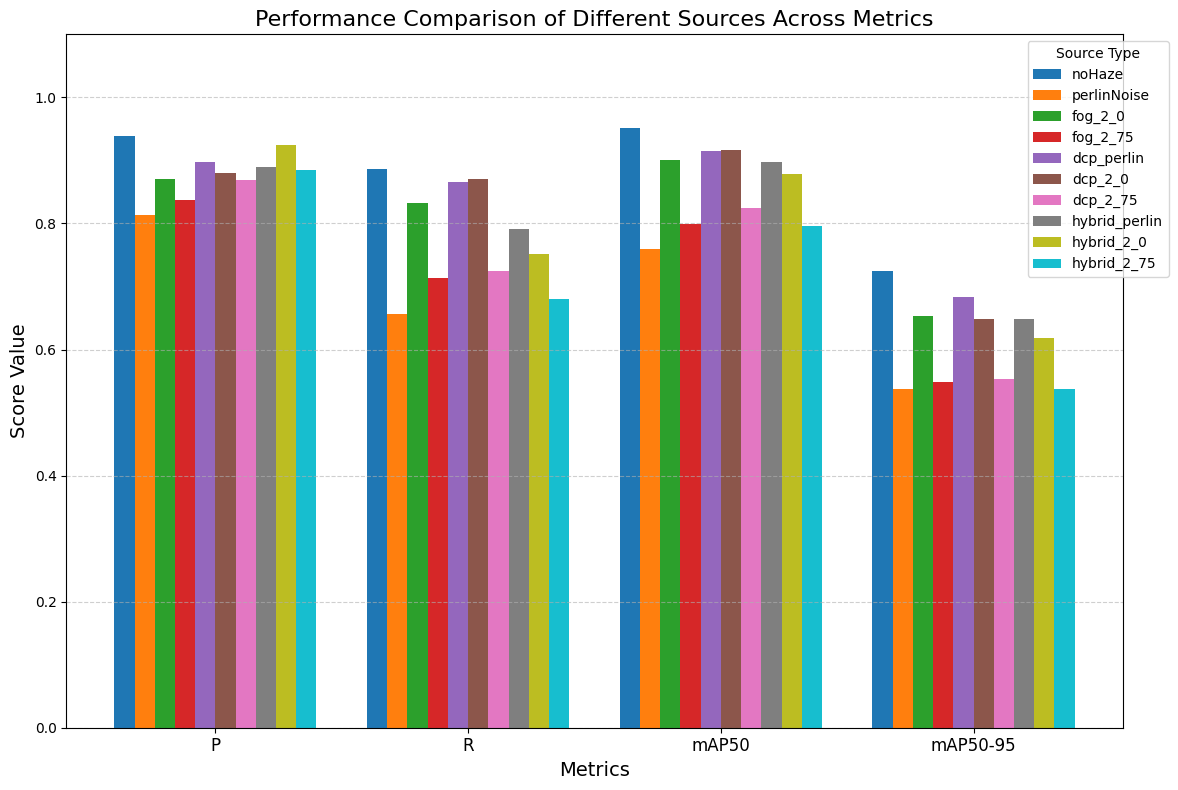

In [1]:
%matplotlib inline
#P, R, mAP50, mAP50-95
noHaze = [0.938, 0.886, 0.951, 0.724]
perlinNoise = [0.813, 0.656, 0.759, 0.537]
fog_2_0 = [0.871, 0.832, 0.901, 0.653]
fog_2_75 = [0.837, 0.713, 0.799, 0.548]

dcp_perlin = [0.897, 0.865, 0.915, 0.684]
dcp_2_0 = [0.88, 0.87, 0.916, 0.649]
dcp_2_75 = [0.869, 0.724, 0.824, 0.554]

hybrid_perlin = [0.89, 0.791, 0.897, 0.648]
hybrid_2_0 = [0.925, 0.751, 0.878, 0.619]
hybrid_2_75 = [0.884, 0.68, 0.796, 0.538]


import matplotlib.pyplot as plt
import numpy as np

# 1. Define your data
metrics = ['P', 'R', 'mAP50', 'mAP50-95']
data_sources = [
    {'label': 'noHaze', 'values': noHaze},
    {'label': 'perlinNoise', 'values': perlinNoise},
    {'label': 'fog_2_0', 'values': fog_2_0},
    {'label': 'fog_2_75', 'values': fog_2_75},
    {'label': 'dcp_perlin', 'values': dcp_perlin},
    {'label': 'dcp_2_0', 'values': dcp_2_0},
    {'label': 'dcp_2_75', 'values': dcp_2_75},
    {'label': 'hybrid_perlin', 'values': hybrid_perlin},
    {'label': 'hybrid_2_0', 'values': hybrid_2_0},
    {'label': 'hybrid_2_75', 'values': hybrid_2_75},
]
fig, ax = plt.subplots(figsize=(14, 8))
num_sources = len(data_sources)
num_metrics = len(metrics)
bar_width = 0.08 # Narrower bars to fit 10 sources side-by-side
indices = np.arange(num_metrics) # The x locations for the groups

# 4. Generate the grouped bars
for i, source in enumerate(data_sources):
    # Offset each source's bars so they sit next to each other within a metric group
    position = indices + i * bar_width
    ax.bar(position, source['values'], bar_width, label=source['label'])

# 5. Customize the graph
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Score Value', fontsize=14)
ax.set_title('Performance Comparison of Different Sources Across Metrics', fontsize=16)
ax.set_xticks(indices + bar_width * (num_sources - 1) / 2) # Center ticks under the group
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim(0, 1.1) # Set Y-limit to a reasonable range for scores
ax.legend(title='Source Type', bbox_to_anchor=(1.05, 1)) # Place legend outside the plot
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for the legend
plt.show()